<img src="https://i.imgur.com/JDsOpVN.png" style="float: left; margin: 20px; height: 290px">

# EDA and Cleaning 

---
Predicting House Prices with Linear Regression

**Author**: Miriam Sosa


1. [Ames Housing Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
2. [Data Cleaning](#Data-Cleaning) 
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Variables of Interest](#Variables-of-Interest)
    - [Explore Relationships](#Explore-Relationships)
    - [Check for Multicollinearity](#Check-for-Multicollinearity)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns 

from sklearn.impute import SimpleImputer

#### Train Data (80% of data)

In [2]:
train = pd.read_csv('../data/train.csv', keep_default_na=False, na_values=[''])
pd.set_option('display.max_columns', None)

#### Test Data (20% of data)

In [3]:
test = pd.read_csv('../data/test.csv',keep_default_na=False, na_values=[''])
pd.set_option('display.max_columns', None)

## Data Cleaning

### Data Shape

In [4]:
train.shape

(2051, 81)

In [5]:
test.shape # 1 less column `missing sale price (target)`

(878, 80)

In [6]:
# Calculate max numbers of features for train
np.sqrt(train.shape[0])

45.28796749689701

Only have 2015 rows. To avoid overfitting, keep the number of features to 45.

### Cleaning Function

In [7]:
def check_for_nulls(df):
    '''
    Identify columns with missing values
    '''
    missing_values = []
    
    for column in df.columns:
        if df[column].isna().sum() > 0:
            missing_values.append(column)
            
    return missing_values

### Null/Missing Values

In [8]:
check_for_nulls(train)

['Lot Frontage',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond']

In [9]:
check_for_nulls(test)

['Lot Frontage',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Electrical',
 'Garage Yr Blt',
 'Garage Finish']

## Combine Features 

In [10]:
# Total Sq FT and Sum number of bathrooms
train['SF'] = train['1st Flr SF'] + train['2nd Flr SF']

In [11]:
train['baths'] = train['Full Bath'] + train['Half Bath'] * 0.5 + train['Bsmt Full Bath'] + train['Bsmt Half Bath'] * 0.5
train['baths'].value_counts()

2.0    636
2.5    391
1.0    314
3.0    278
3.5    199
1.5    193
4.0     22
4.5     11
7.0      2
6.0      2
5.0      1
Name: baths, dtype: int64

In [12]:
train['baths'] = train['baths'].replace(np.nan, 0)
train['baths'].value_counts()

2.0    636
2.5    391
1.0    314
3.0    278
3.5    199
1.5    193
4.0     22
4.5     11
7.0      2
6.0      2
0.0      2
5.0      1
Name: baths, dtype: int64

In [13]:
# Condensed Pool Area to Pool, yes or no
train['pool'] = np.where(train['Pool Area'] > 0, 1, 0)
train['pool'].value_counts()

0    2042
1       9
Name: pool, dtype: int64

In [14]:
# Summed Outdoor SF
train['outdoorSF'] = train['Wood Deck SF'] + train['Open Porch SF']

In [15]:
# Condense condition of house from ordinal scale to binary
train['overallpoor'] = np.where(train['Overall Cond'] < 5, 1, 0)
train['overallpoor'].value_counts()

0    1936
1     115
Name: overallpoor, dtype: int64

In [16]:
# If normal condition, code as normal condition (simplified from list of multiple conditions)
train['cond_norm'] = np.where(train['Condition 1'] == 'Norm', 1, 0)
train['cond_norm'].value_counts()

1    1767
0     284
Name: cond_norm, dtype: int64

In [17]:
# If positive conditions, code as positive condition (simplified from list of multiple conditions)
train['cond_pos'] = np.where(train['Condition 1'] == 'PosN', 1, 
                             np.where(train['Condition 1'] == 'PosA', 1,
                                      np.where(train['Condition 2'] == 'PosN', 1, 
                                               np.where(train['Condition 2'] == 'PoA', 1, 0))))
train['cond_pos'].value_counts()

0    2012
1      39
Name: cond_pos, dtype: int64

In [18]:
# Composite index for garage : 
train['Garage Qual'].value_counts()

TA    1832
NA     113
Fa      82
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64

In [19]:
# Condition of whether garage is ok or not (2, 1)
train['garage_qual'] = np.where(train['Garage Qual'] == 'TA', 2,
                                np.where(train['Garage Qual'] == 'Gd',2, 
                                         np.where(train['Garage Qual'] == 'Ex', 2, 1)))
train['garage_qual'].value_counts()

2    1853
1     198
Name: garage_qual, dtype: int64

In [20]:
# Multiplied by # of cars in garage index for condition and area of garage
train['garage_index'] = train['garage_qual'] * train['Garage Cars']
train['garage_index'].value_counts()

4.0    1117
2.0     481
6.0     261
0.0     113
1.0      62
8.0      13
3.0       2
5.0       1
Name: garage_index, dtype: int64

In [21]:
# Code positive value foundation types vs. all others in a binary variable
train['foundations'] = np.where(train['Foundation'] == 'PConc', 1, 
                       np.where(train['Foundation'] == 'Wood', 1, 0))
train['foundations'].value_counts()

0    1123
1     928
Name: foundations, dtype: int64

In [22]:
# Central Air as a Binary variable
train['central_air'] = np.where(train['Central Air'] == 'Y', 1, 0)
train['central_air'].value_counts()

1    1910
0     141
Name: central_air, dtype: int64

#### Identify Nulls + Recode Train

In [23]:
check_for_nulls(train)

['Lot Frontage',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond',
 'garage_index']

In [24]:
train['Bsmt Half Bath'].value_counts()

0.0    1923
1.0     122
2.0       4
Name: Bsmt Half Bath, dtype: int64

In [25]:
train_no_bsmt = train[train['Bsmt Full Bath'].isnull()].copy()
train_no_bsmt

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SF,baths,pool,outdoorSF,overallpoor,cond_norm,cond_pos,garage_qual,garage_index,foundations,central_air
616,1498,908154080,20,RL,123.0,47007,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NA,NA,NA,0,7,2008,WD,284700,3820,0.0,0,372,0,1,0,2,4.0,0,1
1327,1342,903230120,20,RM,99.0,5940,Pave,NA,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NA,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NA,MnPrv,NA,0,4,2008,ConLD,79000,896,0.0,0,0,0,0,0,2,2.0,1,1


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 92 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

## Recode 

In [27]:
#  Recode nulls as 0s (int and float)
train[['Mas Vnr Area',
      'BsmtFin SF 1',
      'BsmtFin SF 2',
      'Bsmt Unf SF',
      'Total Bsmt SF',
      'Bsmt Full Bath',
      'Bsmt Half Bath',
      'Garage Cars',
      'Garage Area',
      'baths',
      'garage_index',
      'Garage Yr Blt']] = train[['Mas Vnr Area',
                                 'BsmtFin SF 1',
                                 'BsmtFin SF 2',
                                 'Bsmt Unf SF',
                                 'Total Bsmt SF',
                                 'Bsmt Full Bath',
                                 'Bsmt Half Bath',
                                 'Garage Cars',
                                 'Garage Area',
                                 'baths',
                                 'garage_index',
                                 'Garage Yr Blt']].replace(np.nan, 0)

In [28]:
# Recode NA  (strings)

train[['Bsmt Qual',
      'Bsmt Cond',
      'Bsmt Exposure',
      'BsmtFin Type 1',
      'BsmtFin Type 2',
      'Garage Finish',
      'Garage Qual',
      'Garage Cond']] = train[['Bsmt Qual',
                               'Bsmt Cond',
                               'Bsmt Exposure',
                               'BsmtFin Type 1',
                               'BsmtFin Type 2',
                               'Garage Finish',
                               'Garage Qual',
                               'Garage Cond']].replace(np.nan,'NA')

In [29]:
# none (strings)
train[['Mas Vnr Type']] = train[['Mas Vnr Type']].replace(np.nan,'None')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 92 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [31]:
# 114 properties have no garage
train['Garage Finish'].value_counts()

Unf    849
RFn    579
Fin    509
NA     114
Name: Garage Finish, dtype: int64

In [32]:
train.tail()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SF,baths,pool,outdoorSF,overallpoor,cond_norm,cond_pos,garage_qual,garage_index,foundations,central_air
2046,1587,921126030,20,RL,79.0,11449,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1011.0,Unf,0.0,873.0,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,0,NA,NA,NA,0,1,2008,WD,298751,1728,3.0,0,276,0,1,0,2,4.0,1,1
2047,785,905377130,30,RL,NaN,12342,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1940,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,262.0,Unf,0.0,599.0,861.0,GasA,Ex,Y,SBrkr,861,0,0,861,0.0,0.0,1,0,1,1,TA,4,Typ,0,NA,Detchd,1961.0,Unf,2.0,539.0,TA,TA,Y,158,0,0,0,0,0,NA,NA,NA,0,3,2009,WD,82500,861,1.0,0,158,0,1,0,2,4.0,0,1
2048,916,909253010,50,RL,57.0,7558,Pave,NA,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,6,6,1928,1950,Gable,CompShg,BrkFace,Stone,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,896.0,896.0,GasA,Gd,Y,SBrkr,1172,741,0,1913,0.0,0.0,1,1,3,1,TA,9,Typ,1,TA,Detchd,1929.0,Unf,2.0,342.0,Fa,Fa,Y,0,0,0,0,0,0,NA,NA,NA,0,3,2009,WD,177000,1913,1.5,0,0,0,1,0,1,2.0,0,1
2049,639,535179160,20,RL,80.0,10400,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1956,1956,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,155.0,LwQ,750.0,295.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1956.0,Unf,1.0,294.0,TA,TA,Y,0,189,140,0,0,0,NA,NA,NA,0,11,2009,WD,144000,1200,2.0,0,189,0,1,0,2,2.0,0,1
2050,10,527162130,60,RL,60.0,7500,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0.0,Unf,0.0,994.0,994.0,GasA,Gd,Y,SBrkr,1028,776,0,1804,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1999.0,Fin,2.0,442.0,TA,TA,Y,140,60,0,0,0,0,NA,NA,NA,0,6,2010,WD,189000,1804,2.5,0,200,0,1,0,2,4.0,1,1


In [33]:
# Missing values for `garage year built` = no garage
train['Garage Yr Blt']

0       1976.0
1       1997.0
2       1953.0
3       2007.0
4       1957.0
         ...  
2046    2007.0
2047    1961.0
2048    1929.0
2049    1956.0
2050    1999.0
Name: Garage Yr Blt, Length: 2051, dtype: float64

In [34]:
train.tail()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SF,baths,pool,outdoorSF,overallpoor,cond_norm,cond_pos,garage_qual,garage_index,foundations,central_air
2046,1587,921126030,20,RL,79.0,11449,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1011.0,Unf,0.0,873.0,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,0,NA,NA,NA,0,1,2008,WD,298751,1728,3.0,0,276,0,1,0,2,4.0,1,1
2047,785,905377130,30,RL,NaN,12342,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1940,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,262.0,Unf,0.0,599.0,861.0,GasA,Ex,Y,SBrkr,861,0,0,861,0.0,0.0,1,0,1,1,TA,4,Typ,0,NA,Detchd,1961.0,Unf,2.0,539.0,TA,TA,Y,158,0,0,0,0,0,NA,NA,NA,0,3,2009,WD,82500,861,1.0,0,158,0,1,0,2,4.0,0,1
2048,916,909253010,50,RL,57.0,7558,Pave,NA,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,6,6,1928,1950,Gable,CompShg,BrkFace,Stone,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,896.0,896.0,GasA,Gd,Y,SBrkr,1172,741,0,1913,0.0,0.0,1,1,3,1,TA,9,Typ,1,TA,Detchd,1929.0,Unf,2.0,342.0,Fa,Fa,Y,0,0,0,0,0,0,NA,NA,NA,0,3,2009,WD,177000,1913,1.5,0,0,0,1,0,1,2.0,0,1
2049,639,535179160,20,RL,80.0,10400,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1956,1956,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,155.0,LwQ,750.0,295.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1956.0,Unf,1.0,294.0,TA,TA,Y,0,189,140,0,0,0,NA,NA,NA,0,11,2009,WD,144000,1200,2.0,0,189,0,1,0,2,2.0,0,1
2050,10,527162130,60,RL,60.0,7500,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0.0,Unf,0.0,994.0,994.0,GasA,Gd,Y,SBrkr,1028,776,0,1804,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1999.0,Fin,2.0,442.0,TA,TA,Y,140,60,0,0,0,0,NA,NA,NA,0,6,2010,WD,189000,1804,2.5,0,200,0,1,0,2,4.0,1,1


## Imputation 

In [35]:
# Imputation needed for garage built in future (actual date)
train['actualdate'] = np.where(train['Garage Yr Blt'] > 2020,
                              train['Year Built'], np.NaN)
train['actualdate'].value_counts()

2006.0    1
Name: actualdate, dtype: int64

In [36]:
# Actual date of garage built in future, likely the year the house was built
train['Garage Yr Blt'] = np.where(train['Garage Yr Blt'] > 2020,
                                 train['Year Built'],
                                 train['Garage Yr Blt'])

In [37]:
train.drop(columns=['actualdate'], inplace=True)

In [38]:
train['Lot Config'].value_counts()

Inside     1503
Corner      348
CulDSac     131
FR2          60
FR3           9
Name: Lot Config, dtype: int64

In [39]:
train.rename(columns={'Lot Config': 'LotConfig',
                     'Lot Frontage' : 'LotFrontage'},
                    inplace = True)

In [40]:
train.rename(columns={'Lot Shape': 'LotShape'}, inplace = True) # combat error above 

In [41]:
# Investigate LotFrontage w/ missing data to help guide imputation, 
# As missing does not appear to mean 0

In [42]:
pd.crosstab(train.LotConfig, train.LotShape)

LotShape,IR1,IR2,IR3,Reg
LotConfig,,,,
Corner,140,6,4,198
CulDSac,106,23,0,2
FR2,12,7,0,41
FR3,4,0,0,5
Inside,430,19,5,1049


In [43]:
train['Lot0'] = train['LotFrontage'].fillna(0)
pd.crosstab(train.LotConfig, train.Lot0)

Lot0,0.0,21.0,22.0,24.0,25.0,26.0,30.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0,118.0,119.0,120.0,121.0,122.0,123.0,124.0,125.0,128.0,129.0,130.0,134.0,135.0,137.0,138.0,140.0,141.0,144.0,150.0,153.0,155.0,160.0,174.0,195.0,200.0,313.0
LotConfig,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Corner,67,0,0,1,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,9,3,0,4,0,0,1,1,1,2,26,1,3,5,4,6,2,2,2,2,10,3,5,4,4,11,1,1,2,4,15,6,2,2,5,8,1,3,7,2,15,4,5,2,4,5,1,3,2,1,7,2,3,2,0,3,1,2,3,2,4,1,2,2,2,0,1,1,0,1,7,0,1,0,1,2,0,1,0,2,1,1,0,2,1,0,1,1,0,0,0,0,0,1
CulDSac,61,0,1,0,1,0,1,1,0,0,1,0,1,1,2,2,1,2,7,2,2,1,3,2,2,4,0,2,1,0,0,3,2,1,3,2,0,0,2,1,0,1,0,0,0,1,1,1,2,0,0,1,0,1,0,0,0,2,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FR2,11,0,0,6,0,3,0,3,0,0,1,0,0,1,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2,1,0,4,0,1,2,1,2,0,1,1,0,4,0,0,0,0,0,0,1,0,0,2,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
FR3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Inside,190,32,0,26,0,0,10,2,1,9,11,5,4,2,2,10,8,6,13,9,4,1,2,9,1,76,13,18,13,6,14,11,15,10,12,145,9,24,29,25,63,16,15,25,12,80,9,24,19,27,57,14,9,30,15,77,8,17,8,9,42,6,4,9,4,14,9,6,6,4,6,8,0,4,1,15,0,4,3,3,6,2,7,1,2,5,0,1,0,2,1,0,0,0,0,0,1,0,1,0,1,3,1,2,1,0,0,1,0,0,1,0,0,1,1,1,0,1,1


In [44]:
pd.crosstab(train.LotShape, train.Lot0)

Lot0,0.0,21.0,22.0,24.0,25.0,26.0,30.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0,118.0,119.0,120.0,121.0,122.0,123.0,124.0,125.0,128.0,129.0,130.0,134.0,135.0,137.0,138.0,140.0,141.0,144.0,150.0,153.0,155.0,160.0,174.0,195.0,200.0,313.0
LotShape,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
IR1,223,0,0,0,1,1,2,2,0,3,6,1,3,3,4,6,5,5,5,8,2,1,3,3,3,12,2,1,2,1,3,5,10,6,11,9,5,6,7,7,19,6,5,12,5,15,5,10,8,13,13,7,6,7,11,11,3,11,2,2,11,5,5,9,2,8,5,6,3,3,4,5,4,5,2,12,2,5,2,1,3,2,4,2,1,4,0,2,1,2,0,1,1,1,0,2,1,1,1,1,1,2,2,1,2,0,1,1,0,1,0,0,1,1,0,1,1,0,0
IR2,19,0,1,0,0,2,1,0,0,0,0,0,0,1,0,0,2,0,4,1,1,0,2,1,0,2,0,1,0,0,1,0,2,1,3,1,0,0,0,0,1,1,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
IR3,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Reg,85,32,0,33,0,0,7,4,1,8,7,4,3,0,0,7,4,3,11,3,5,1,1,7,0,76,14,18,16,5,10,10,8,6,4,168,5,22,31,24,51,11,12,16,9,79,8,20,16,18,55,9,5,26,8,83,11,9,8,12,41,2,3,7,4,21,8,7,6,5,7,6,0,2,1,11,0,2,3,2,6,1,5,2,3,5,1,1,1,2,1,0,0,0,1,6,0,0,0,0,2,1,2,1,1,0,0,0,2,0,1,1,0,0,1,0,0,1,0


In [45]:
train.drop(['Lot0'], axis=1)

,Id,PID,MS SubClass,MS Zoning,LotFrontage,Lot Area,Street,Alley,LotShape,Land Contour,Utilities,LotConfig,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SF,baths,pool,outdoorSF,overallpoor,cond_norm,cond_pos,garage_qual,garage_index,foundations,central_air
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NA,NA,NA,0,3,2010,WD,130500,1479,2.5,0,44,0,0,0,2,4.0,0,1
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NA,NA,NA,0,4,2009,WD,220000,2122,3.5,0,74,0,1,0,2,4.0,1,1
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NA,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NA,NA,NA,0,1,2010,WD,109000,1057,2.0,0,52,0,1,0,2,2.0,0,1
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NA,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,174000,1444,2.5,0,100,0,1,0,2,4.0,1,1
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NA,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NA,NA,NA,0,3,2010,WD,138500,1445,2.0,0,59,0,1,0,2,4.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1011.0,Unf,0.0,873.0,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,0,NA,NA,NA,0,1,2008,WD,298751,1728,3.0,0,276,0,1,0,2,4.0,1,1
2047,785,905377130,30,RL,NaN,12342,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1940,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,262.0,Unf,0.0,599.0,861.0,GasA,Ex,Y,SBrkr,861,0,0,861,0.0,0.0,1,0,1,1,TA,4,Typ,0,NA,Detchd,1961.0,Unf,2.0,539.0,TA,TA,Y,158,0,0,0,0,0,NA,NA,NA,0,3,2009,WD,82500,861,1.0,0,158,0,1,0,2,4.0,0,

In [46]:
train['LotFrontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [47]:
# Impute values for LotFrontage using median
# LotFrontage appears missing at random, which qualifies simple imputation attempt

imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
transformed_values = imputer.fit_transform(train['LotFrontage'].values.reshape(-1, 1))[:,0]
transformed_values

array([68., 43., 68., ..., 57., 80., 60.])

In [48]:
train['LotFrontage'] = transformed_values
train

,Id,PID,MS SubClass,MS Zoning,LotFrontage,Lot Area,Street,Alley,LotShape,Land Contour,Utilities,LotConfig,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SF,baths,pool,outdoorSF,overallpoor,cond_norm,cond_pos,garage_qual,garage_index,foundations,central_air,Lot0
0,109,533352170,60,RL,68.0,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NA,NA,NA,0,3,2010,WD,130500,1479,2.5,0,44,0,0,0,2,4.0,0,1,0.0
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NA,NA,NA,0,4,2009,WD,220000,2122,3.5,0,74,0,1,0,2,4.0,1,1,43.0
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NA,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NA,NA,NA,0,1,2010,WD,109000,1057,2.0,0,52,0,1,0,2,2.0,0,1,68.0
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NA,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,174000,1444,2.5,0,100,0,1,0,2,4.0,1,1,73.0
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NA,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NA,NA,NA,0,3,2010,WD,138500,1445,2.0,0,59,0,1,0,2,4.0,1,1,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1011.0,Unf,0.0,873.0,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,0,NA,NA,NA,0,1,2008,WD,298751,1728,3.0,0,276,0,1,0,2,4.0,1,1,79.0
2047,785,905377130,30,RL,68.0,12342,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1940,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,262.0,Unf,0.0,599.0,861.0,GasA,Ex,Y,SBrkr,861,0,0,861,0.0,0.0,1,0,1,1,TA,4,Typ,0,NA,Detchd,1961.0,Unf,2.0,539.0,TA,TA,Y,158,0,0,0,0,0,NA,NA,NA,0,3,20

## Clean Data

In [49]:
check_for_nulls(train)

[]

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 93 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   LotFrontage      2051 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   LotShape         2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  LotConfig        2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [51]:
train.to_csv('../data/train_clean.csv', index=False)

## Apply Identical Changes 

In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            878 non-null    object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [53]:
check_for_nulls(test)

['Lot Frontage',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Electrical',
 'Garage Yr Blt',
 'Garage Finish']

In [54]:
test['SF'] = test['1st Flr SF'] + test['2nd Flr SF']

In [55]:
test['baths'] = test['Full Bath'] + test['Half Bath'] * 0.5 + test['Bsmt Full Bath'] + test['Bsmt Half Bath'] * 0.5

In [56]:
test['baths'] = test['baths'].replace(np.nan,0)
test['baths'].value_counts()

2.0    275
2.5    169
1.0    128
3.0    100
1.5    100
3.5     89
4.0      9
4.5      5
5.0      2
7.0      1
Name: baths, dtype: int64

In [57]:
test['pool'] = np.where(test['Pool Area'] > 0, 1, 0)
test['pool'].value_counts()

0    874
1      4
Name: pool, dtype: int64

In [58]:
test['outdoorSF'] = test['Wood Deck SF'] + test['Open Porch SF']
test['outdoorSF']

0       60
1      170
2      124
3        0
4       76
      ... 
873     96
874    230
875     63
876      0
877     81
Name: outdoorSF, Length: 878, dtype: int64

In [59]:
test['overallpoor'] = np.where(test['Overall Cond'] < 5, 1, 0)
test['overallpoor'].value_counts()

0    825
1     53
Name: overallpoor, dtype: int64

In [60]:
test['cond_norm'] = np.where(test['Condition 1'] == 'Norm', 1, 0)
test['cond_norm'].value_counts()

1    755
0    123
Name: cond_norm, dtype: int64

In [61]:
# If any positive conditions are true then code
test['cond_pos'] = np.where(test['Condition 1'] == 'PosN', 1, 
                   np.where(test['Condition 1'] == 'PosA', 1,
                   np.where(test['Condition 2'] == 'PosN', 1,
                   np.where(test['Condition 2'] == 'PosA', 1, 0))))
test['cond_pos'].value_counts()

0    859
1     19
Name: cond_pos, dtype: int64

In [62]:
test['garage_qual'] = np.where(test['Garage Qual'] == 'TA', 2, 
                      np.where(test['Garage Qual'] == 'Gd', 2, 
                      np.where(test['Garage Qual'] == 'Ex', 2, 1)))
test['garage_qual'].value_counts()

2    788
1     90
Name: garage_qual, dtype: int64

In [63]:
test['garage_index'] = test['garage_qual'] * test['Garage Cars']
test['garage_index'].value_counts()

4    456
2    234
6    109
0     44
1     32
8      2
3      1
Name: garage_index, dtype: int64

In [64]:
test['foundations'] = np.where(test['Foundation'] == 'PConc', 1,
                      np.where(test['Foundation'] == 'Wood', 1, 0))
test['foundations'].value_counts()

0    492
1    386
Name: foundations, dtype: int64

In [65]:
test['central_air'] = np.where(test['Central Air'] == 'Y', 1, 0)
test['central_air'].value_counts()

1    823
0     55
Name: central_air, dtype: int64

In [66]:
check_for_nulls(test)

['Lot Frontage',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Electrical',
 'Garage Yr Blt',
 'Garage Finish']

In [67]:
test[['Mas Vnr Area']] = test['Mas Vnr Area'].replace(np.nan, 0)

In [68]:
test[['Garage Yr Blt']] = test['Garage Yr Blt'].replace(np.nan, 0)

In [69]:
test[['Mas Vnr Type', 'Garage Finish']] = test[['Mas Vnr Type', 'Garage Finish']].replace(np.nan, 'None')

In [70]:
test[['Electrical']] = test['Electrical'].replace(np.nan, 'S8rkr')

In [71]:
imputer = SimpleImputer(missing_values = np.NaN, strategy = 'median')
transformed_values = imputer.fit_transform(test['Lot Frontage'].values.reshape(-1, 1))[:,0]

In [72]:
test['Lot Frontage'] = transformed_values

In [73]:
test.rename(columns = {'Lot Config' : 'LotConfig',
                      'Lot Shape' : 'LotShape',
                      'Lot Frontage' : 'LotFrontage'},
           inplace = True)

In [92]:
check_for_nulls(test)

[]

In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 91 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   LotFrontage      878 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            878 non-null    object 
 8   LotShape         878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  LotConfig        878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [75]:
test.to_csv('../data/test_clean.csv', index = False)

## Exploratory Data Analysis

In [76]:
# Masonry veneer type
train['Mas Vnr Type'].value_counts()

None       1240
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [77]:
# df for non-zero values
train_mas = train[train['Mas Vnr Area'] > 0]

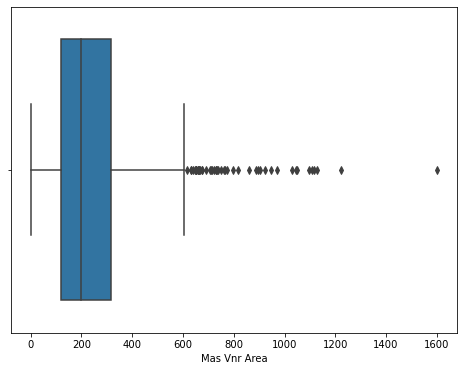

In [78]:
# Evaluate distribution of NAs
plt.figure(figsize = (8,6))
sns.boxplot(x=train_mas['Mas Vnr Area']);

## Variables of Interest

In [79]:
continuous = train[['LotFrontage',
                   'Lot Area',
                   'Year Built',
                   'BsmtFin SF 1',
                   'SF',
                   'Low Qual Fin SF',
                   'TotRms AbvGrd',
                   'Garage Yr Blt',
                   'Garage Cars',
                   'Garage Area',
                   'outdoorSF']]

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 93 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   LotFrontage      2051 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   LotShape         2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  LotConfig        2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

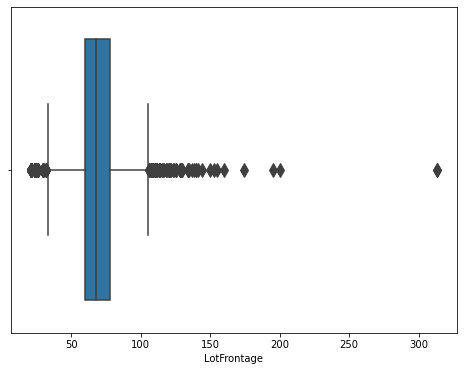

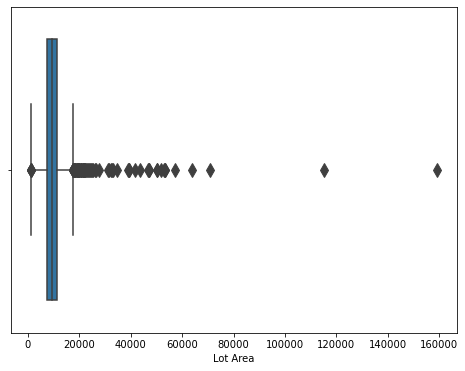

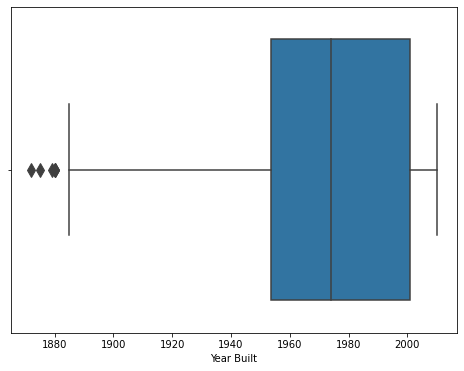

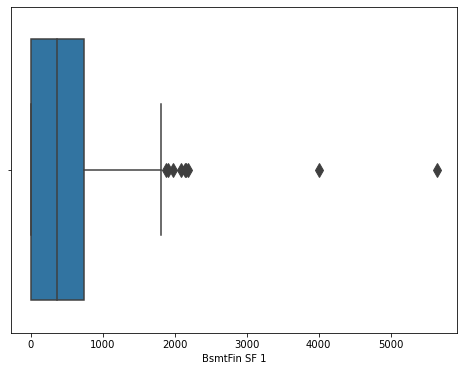

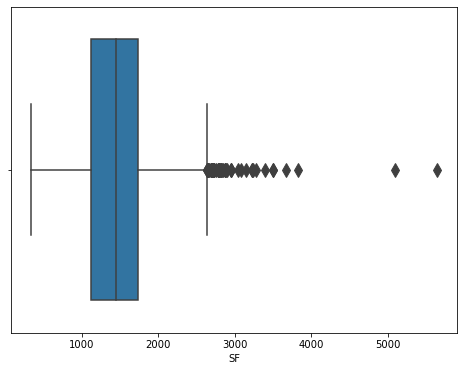

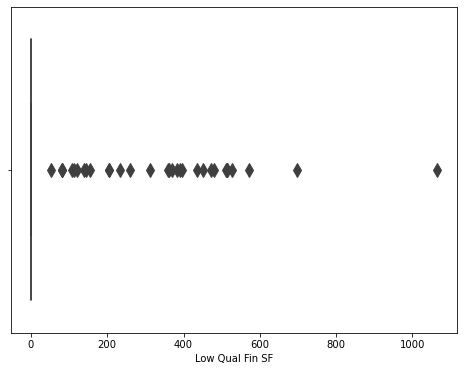

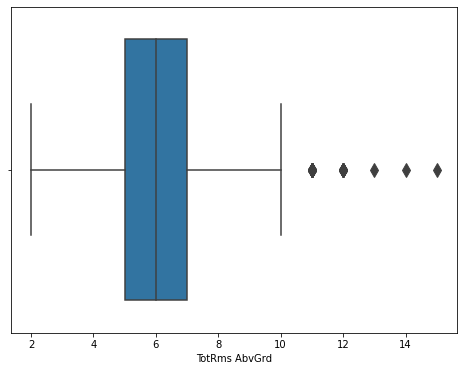

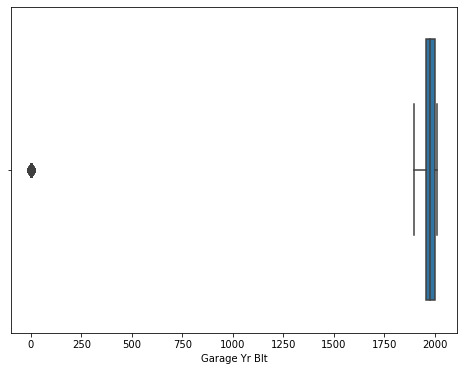

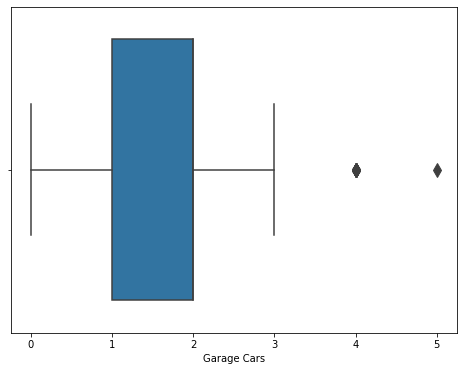

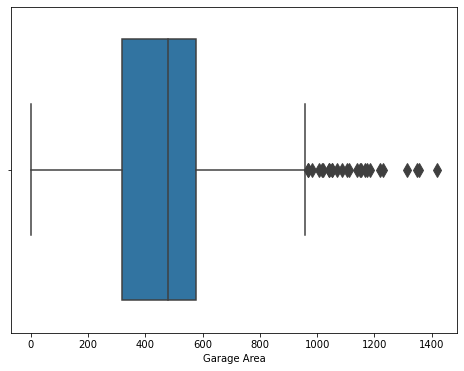

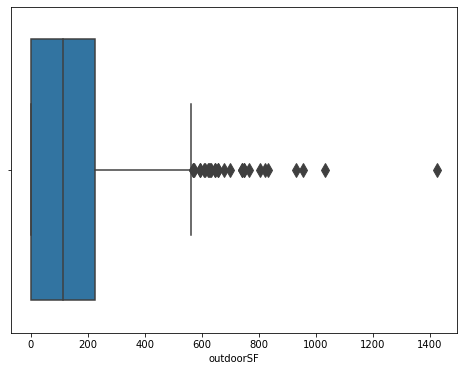

In [81]:
for i in continuous:
    plt.figure(i, figsize = (8, 6))
    sns.boxplot(x = train[i], fliersize=10);

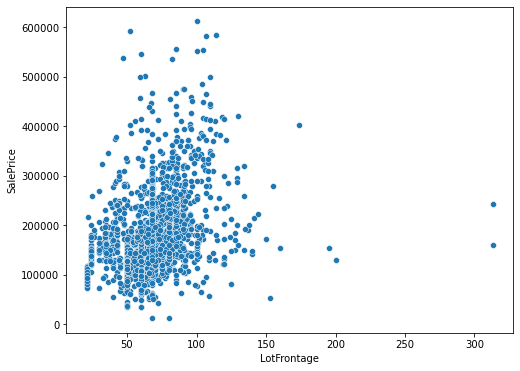

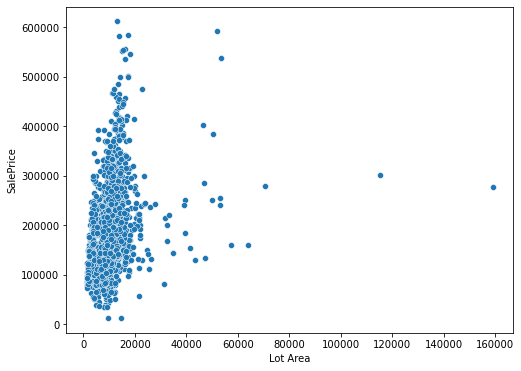

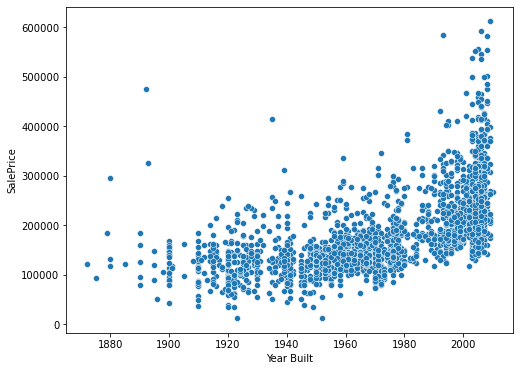

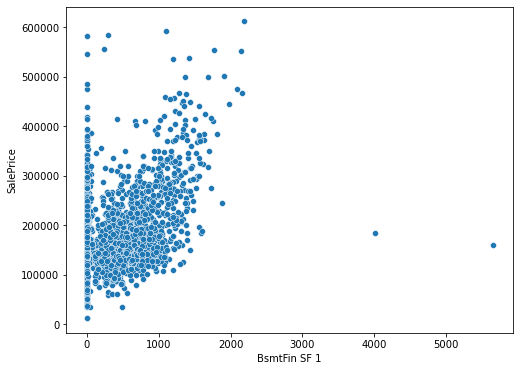

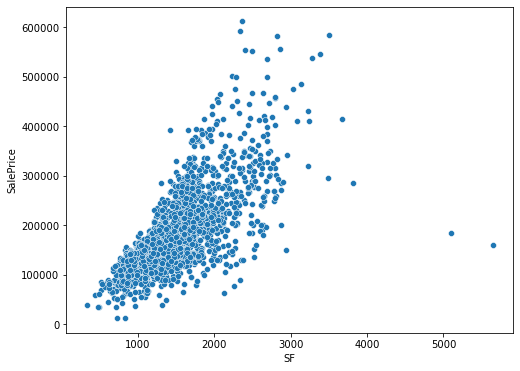

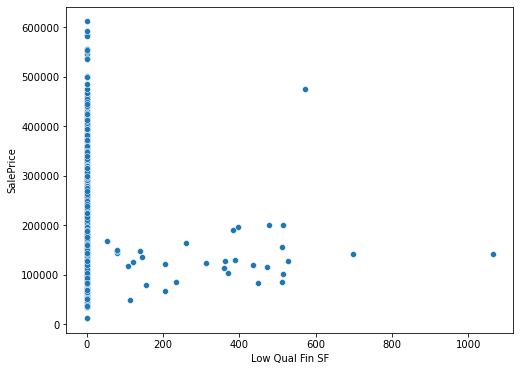

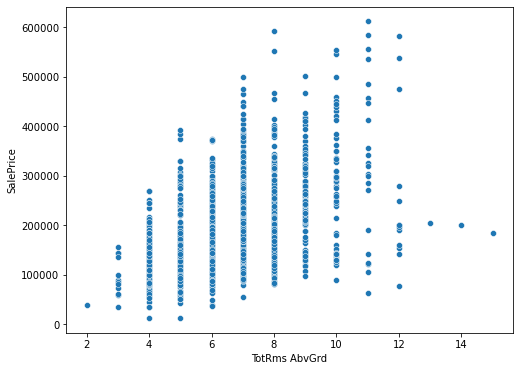

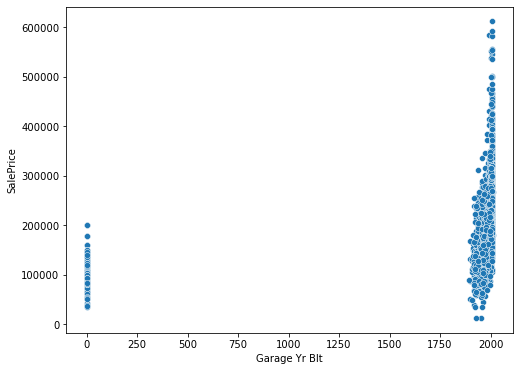

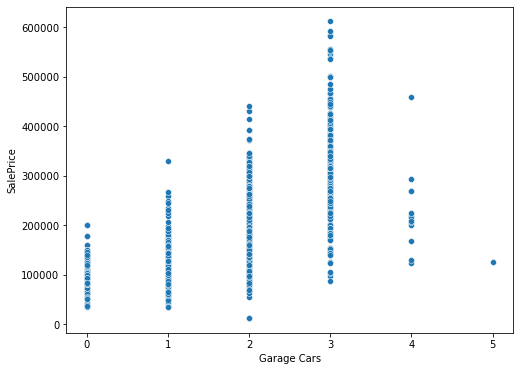

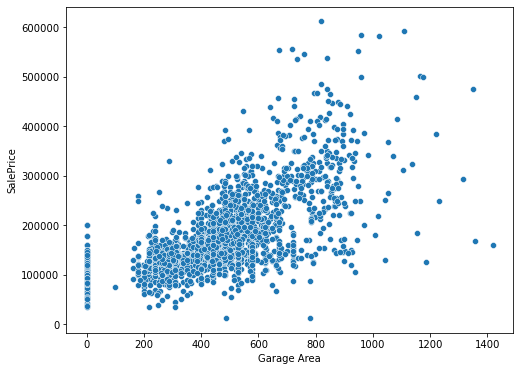

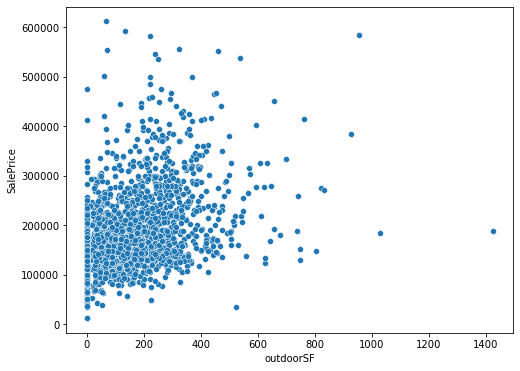

In [82]:
for i in continuous:
    plt.figure(i, figsize=(8,6))
    sns.scatterplot(x = train[i],
                   y = train['SalePrice']);

In [83]:
cat = train[['MS SubClass',
             'MS Zoning',
             'LotConfig',
             'Neighborhood',
             'Condition 1',
             'Condition 2',
             'Bldg Type',
             'Overall Qual',
             'Overall Cond',
             'Exterior 1st',
             'Exterior 2nd',
             'Mas Vnr Type', 
             'Foundation',
             'Bsmt Cond',
             'BsmtFin Type 1',
             'Heating',
             'Heating QC',
             'Central Air',
             'Electrical',
             'Bsmt Full Bath',
             'Bsmt Half Bath',
             'Full Bath',
             'Half Bath',
             'Functional',
             'Garage Type',
             'Garage Qual',
             'Garage Cond',
             'Paved Drive',
             'Pool Area',
             'Pool QC',
             'Fence',
             'Misc Feature']]

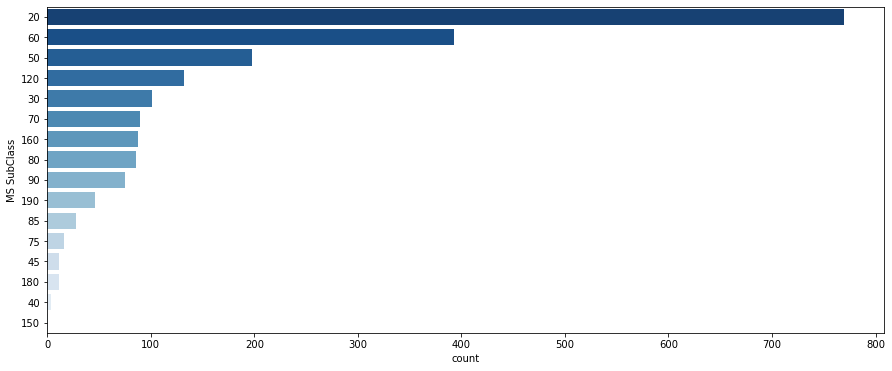

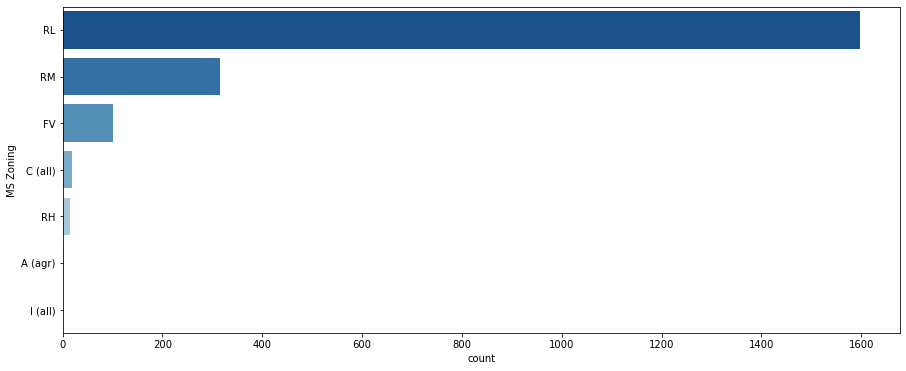

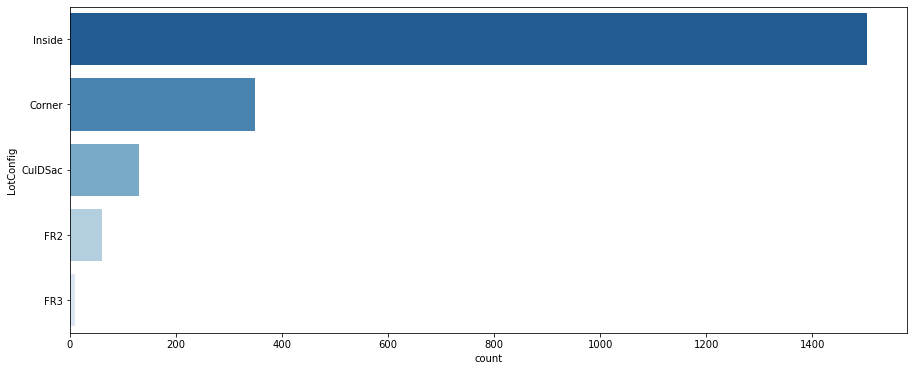

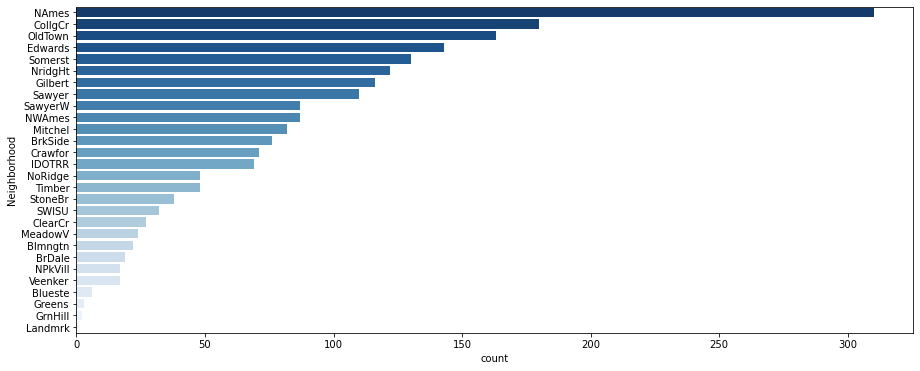

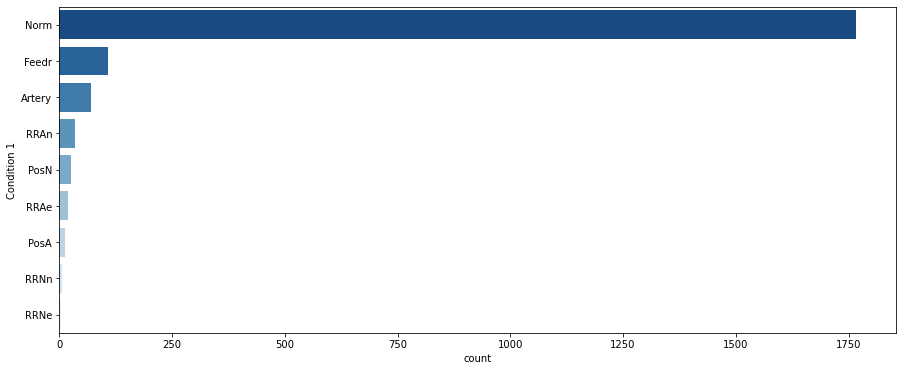

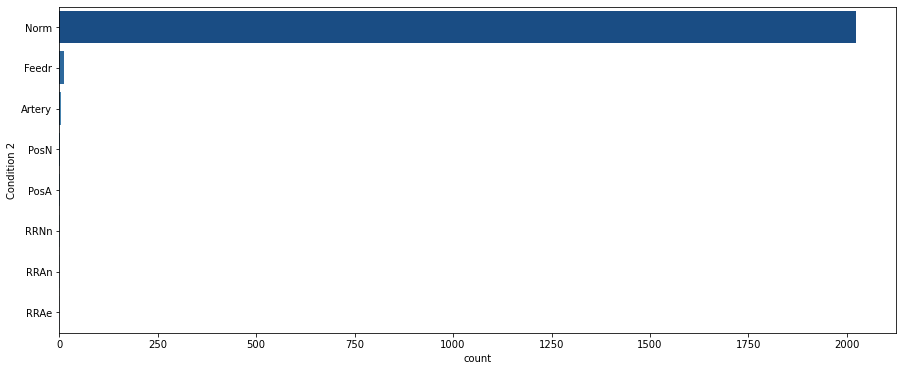

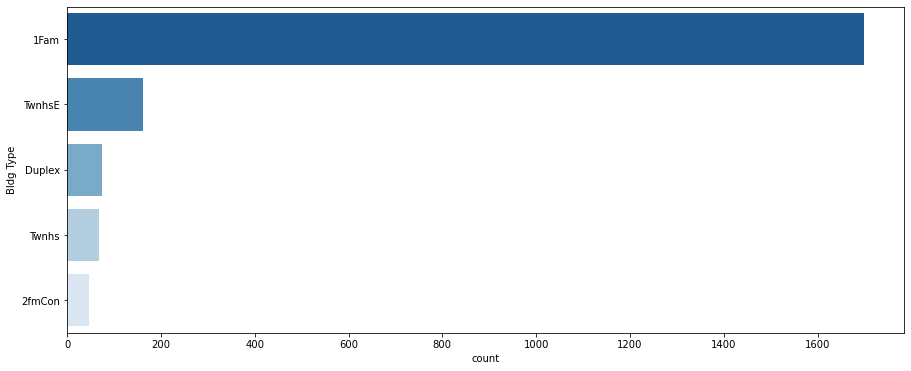

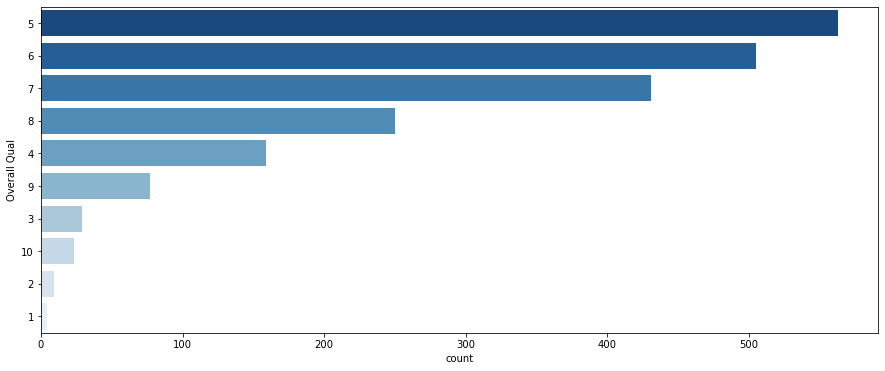

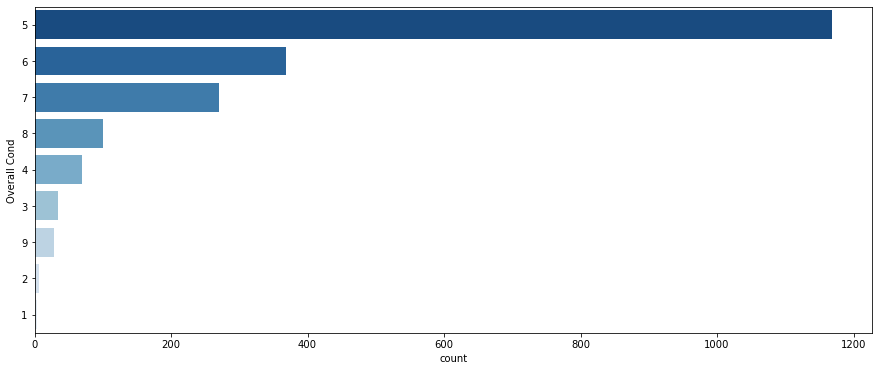

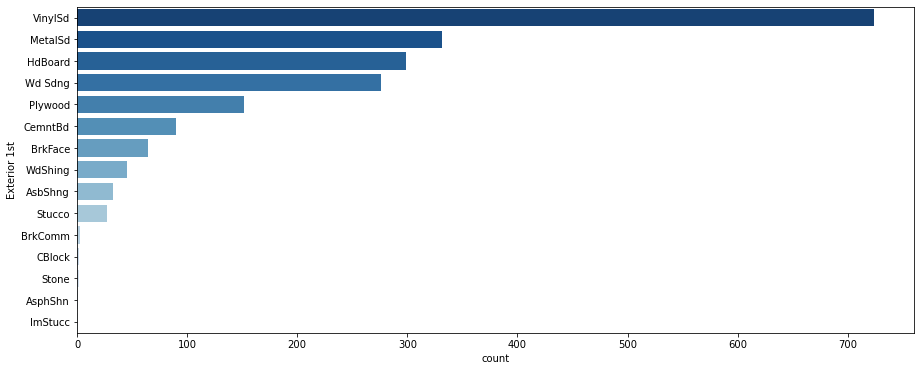

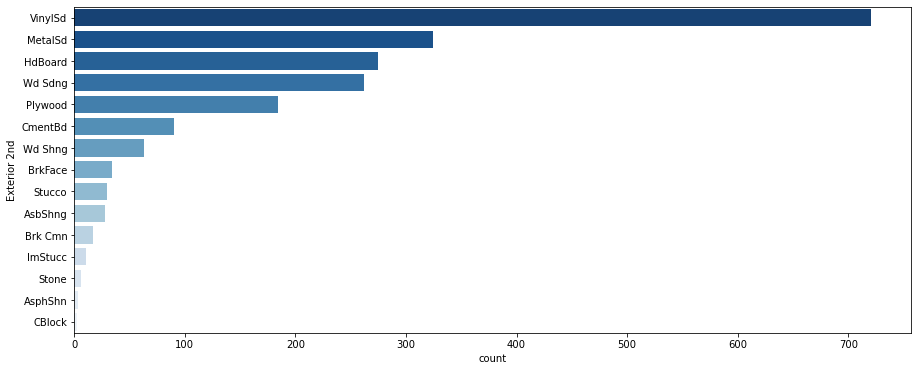

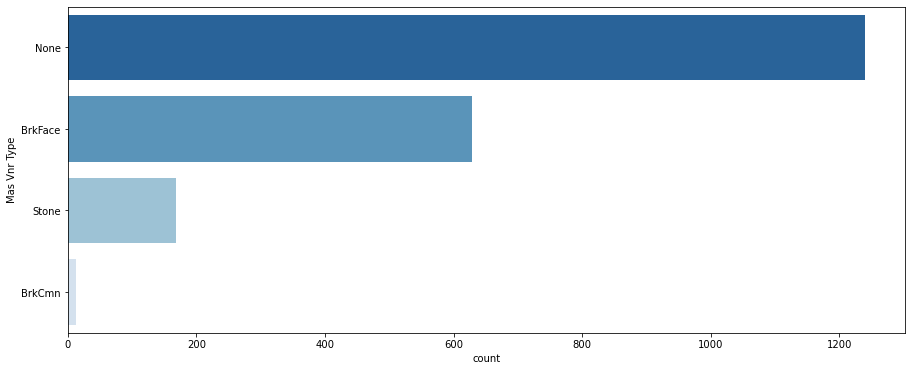

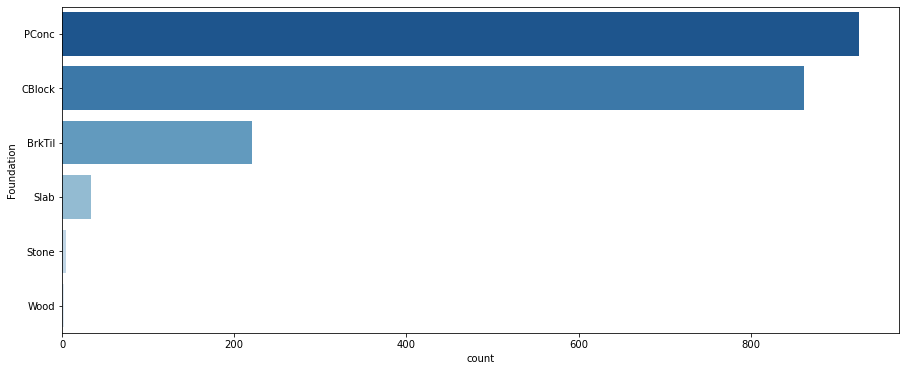

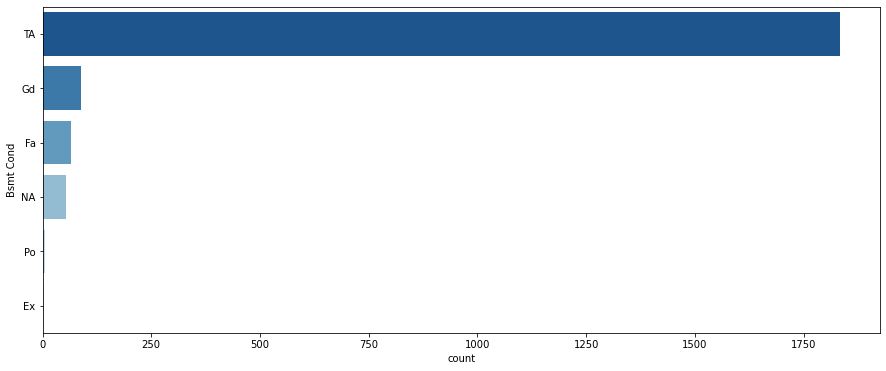

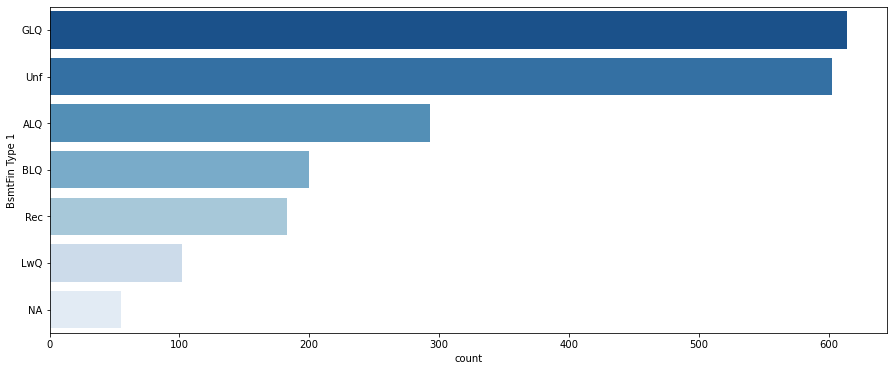

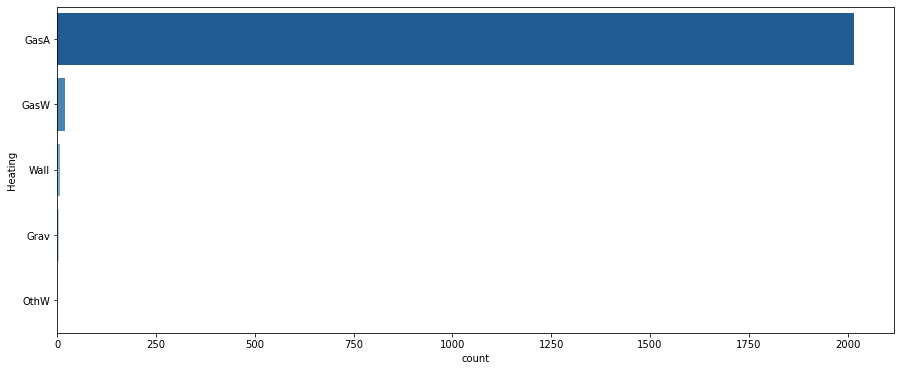

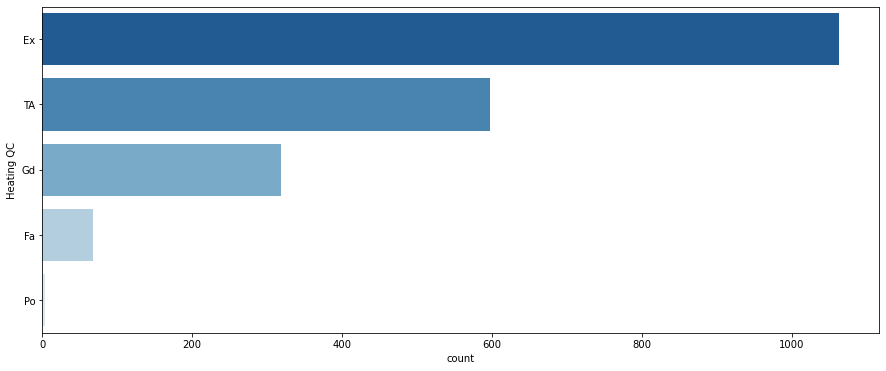

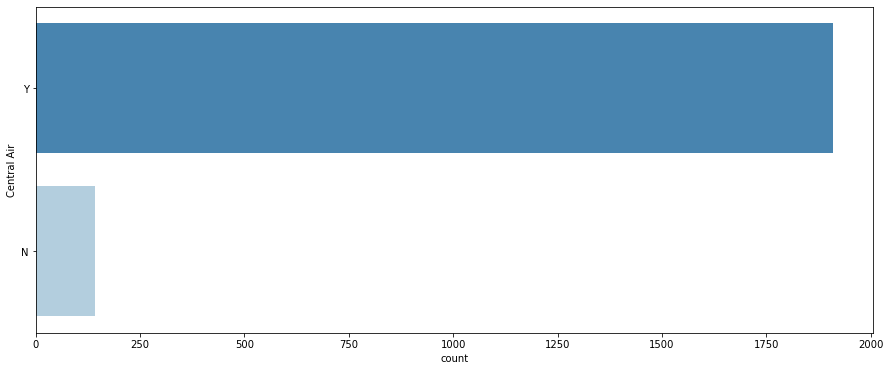

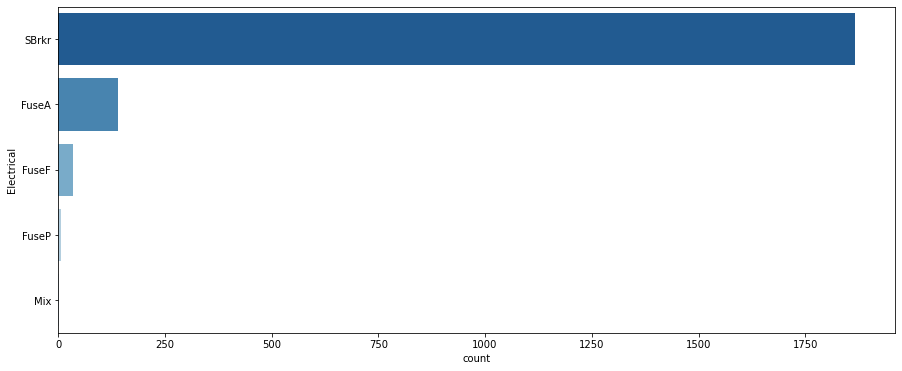

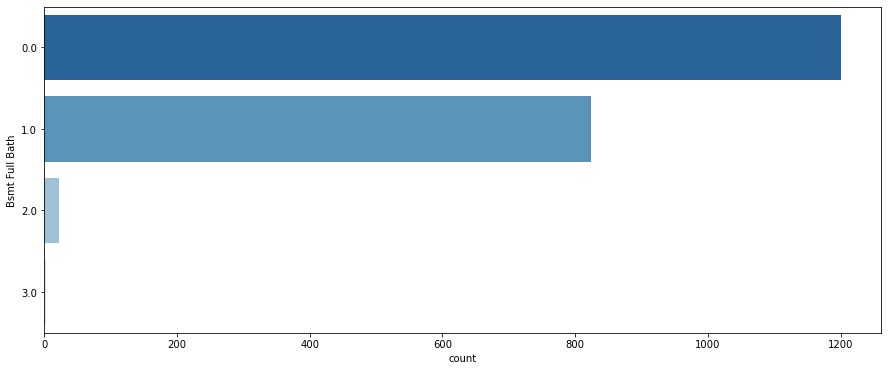

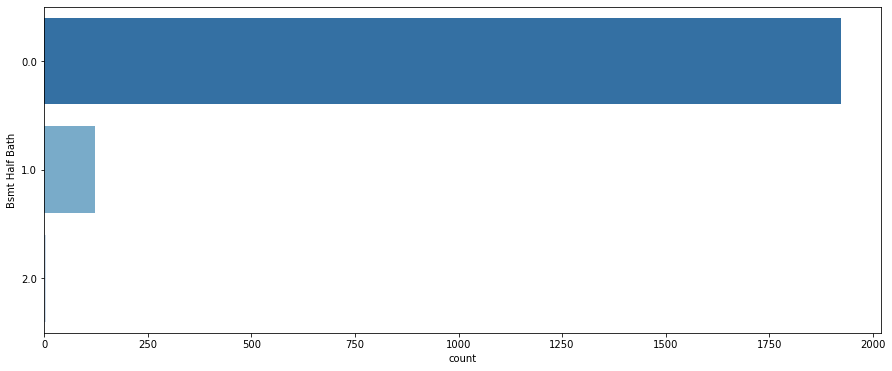

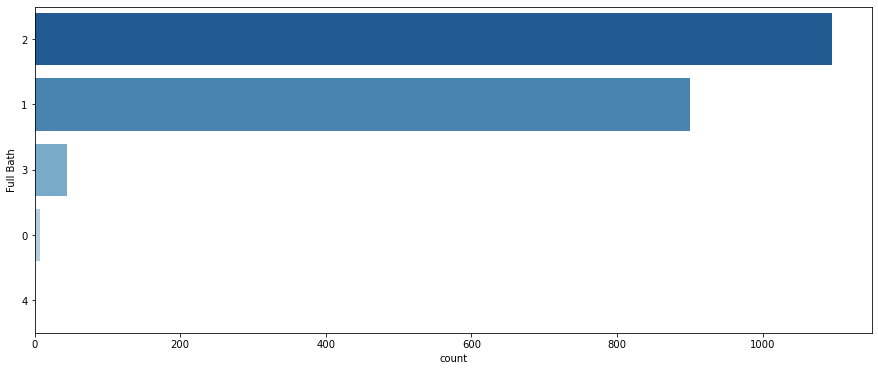

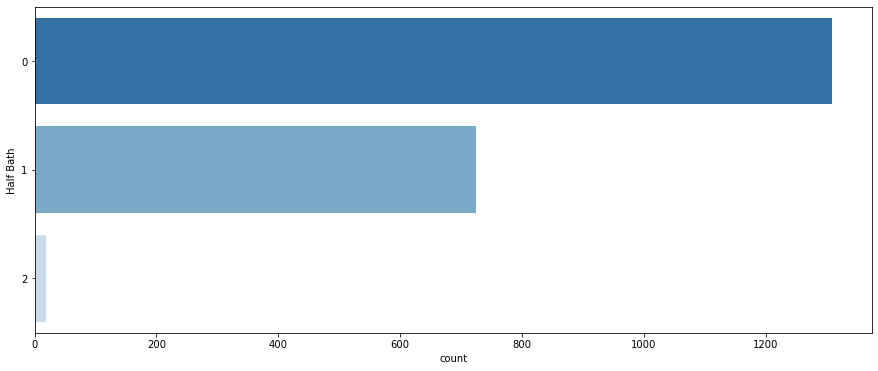

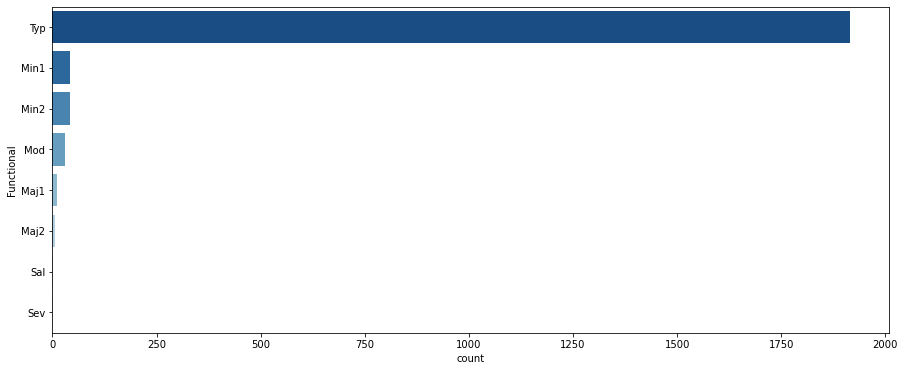

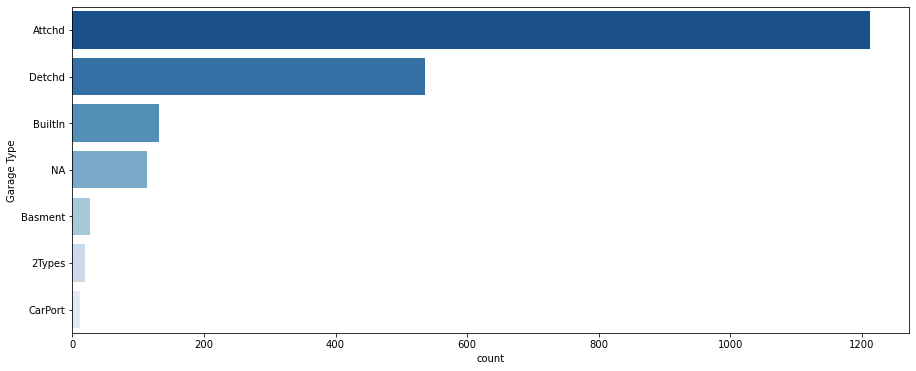

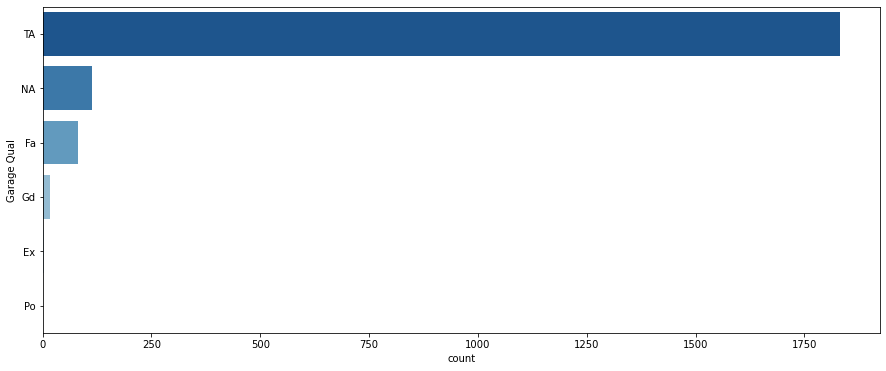

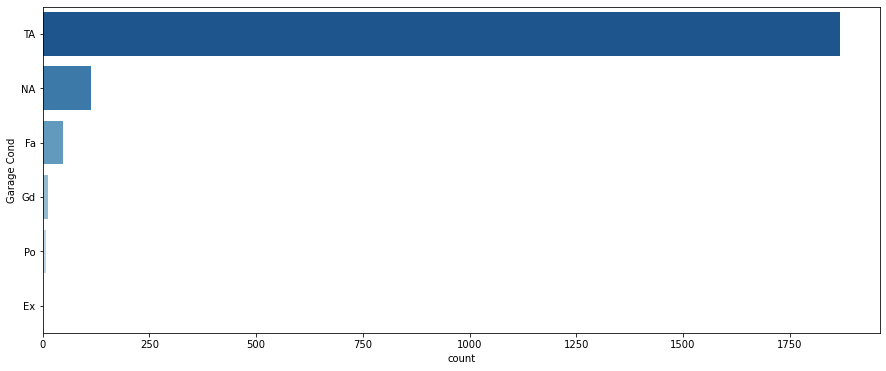

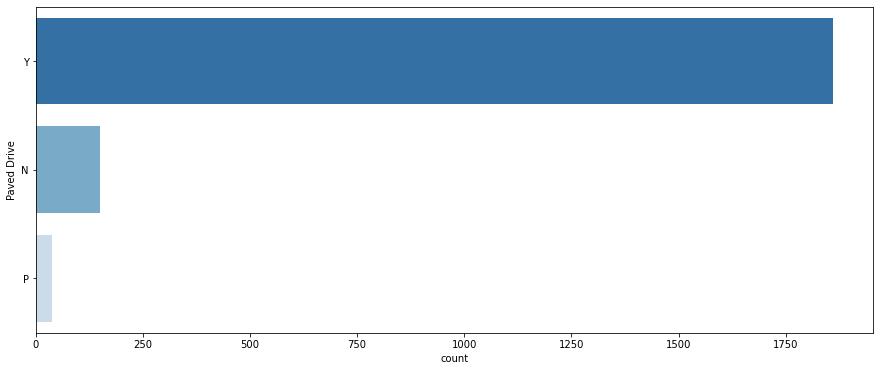

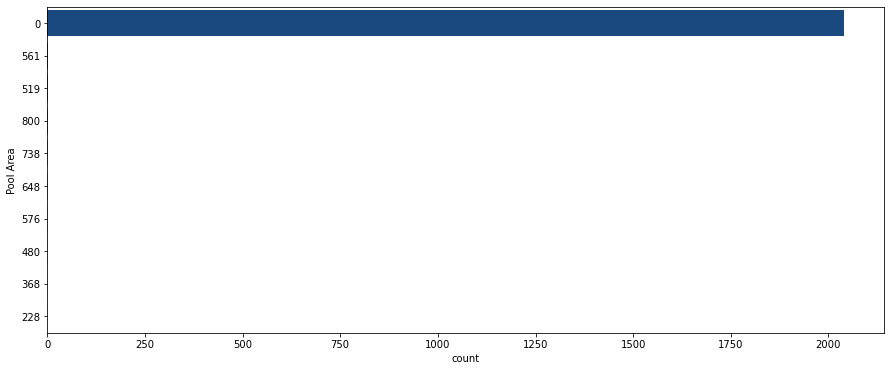

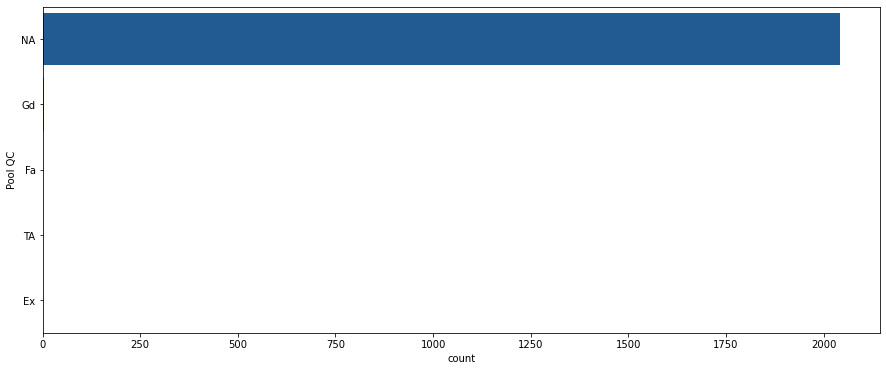

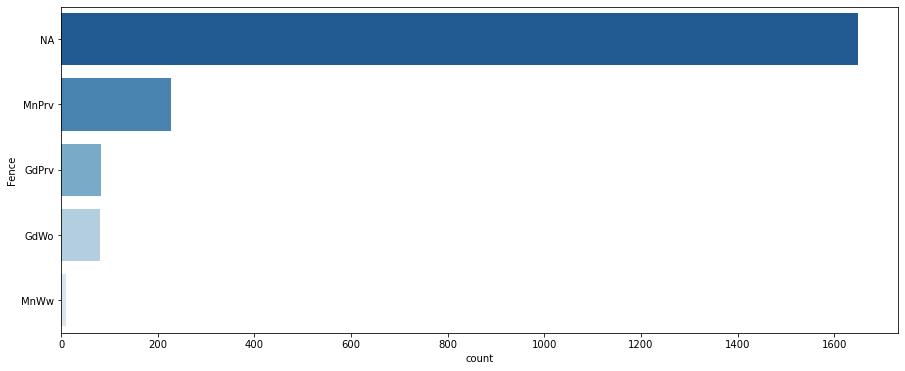

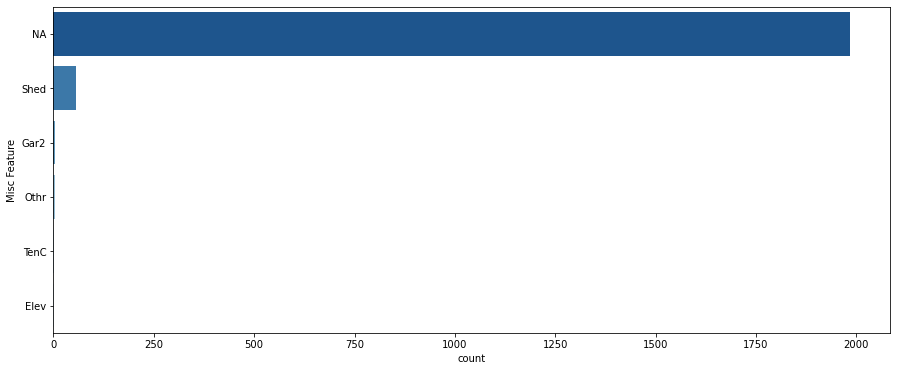

In [84]:
for i in cat:
    fig, ax = plt.subplots(1,1, figsize = (15,6))
    sns.countplot(y = cat[i][1:], data = cat.iloc[1:], order = cat[i][1:].value_counts().index, palette='Blues_r' )
    plt.rcParams.update({'figure.max_open_warning': 0}) # https://stackoverflow.com/questions/27476642/matplotlib-get-rid-of-max-open-warning-output

In [85]:
for col in train.columns:
    print(col)

Id
PID
MS SubClass
MS Zoning
LotFrontage
Lot Area
Street
Alley
LotShape
Land Contour
Utilities
LotConfig
Land Slope
Neighborhood
Condition 1
Condition 2
Bldg Type
House Style
Overall Qual
Overall Cond
Year Built
Year Remod/Add
Roof Style
Roof Matl
Exterior 1st
Exterior 2nd
Mas Vnr Type
Mas Vnr Area
Exter Qual
Exter Cond
Foundation
Bsmt Qual
Bsmt Cond
Bsmt Exposure
BsmtFin Type 1
BsmtFin SF 1
BsmtFin Type 2
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
Heating
Heating QC
Central Air
Electrical
1st Flr SF
2nd Flr SF
Low Qual Fin SF
Gr Liv Area
Bsmt Full Bath
Bsmt Half Bath
Full Bath
Half Bath
Bedroom AbvGr
Kitchen AbvGr
Kitchen Qual
TotRms AbvGrd
Functional
Fireplaces
Fireplace Qu
Garage Type
Garage Yr Blt
Garage Finish
Garage Cars
Garage Area
Garage Qual
Garage Cond
Paved Drive
Wood Deck SF
Open Porch SF
Enclosed Porch
3Ssn Porch
Screen Porch
Pool Area
Pool QC
Fence
Misc Feature
Misc Val
Mo Sold
Yr Sold
Sale Type
SalePrice
SF
baths
pool
outdoorSF
overallpoor
cond_norm
cond_pos
garage_qual
gara

## Explore Relationships 

`of predictor to outcome`

In [86]:
cat_preds = train[['MS Zoning',
                  'Utilities',
                  'LotConfig',
                  'Neighborhood',
                  'Condition 1',
                  'Condition 2',
                  'Overall Cond',
                  'Mas Vnr Type',
                  'Foundation',
                  'Bsmt Cond',
                  'Heating',
                  'Central Air',
                  'Garage Type',
                  'Garage Cars', 
                  'Garage Cond',
                  'Mo Sold',
                  'Yr Sold',
                  'pool']]

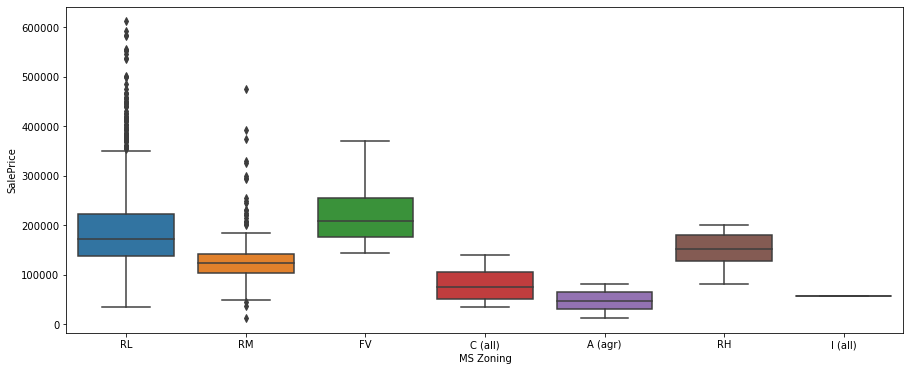

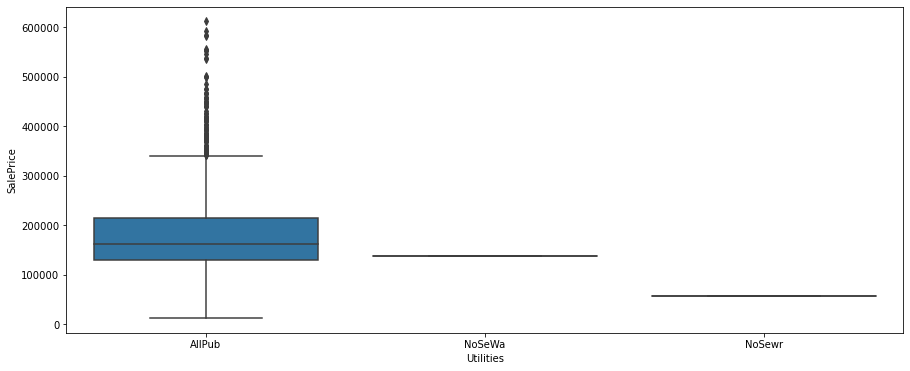

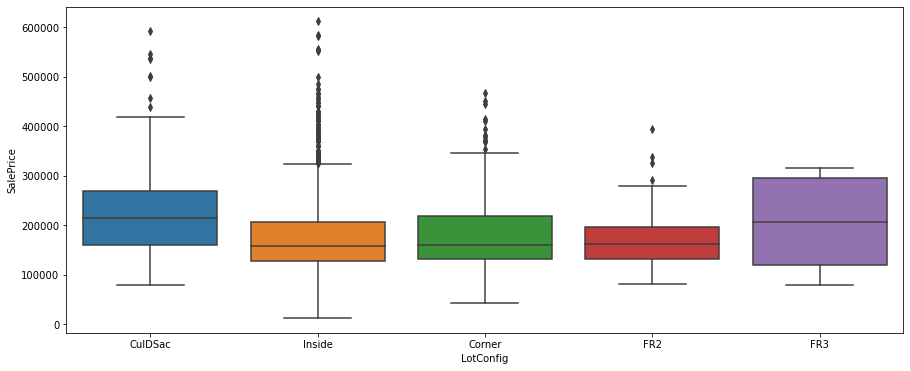

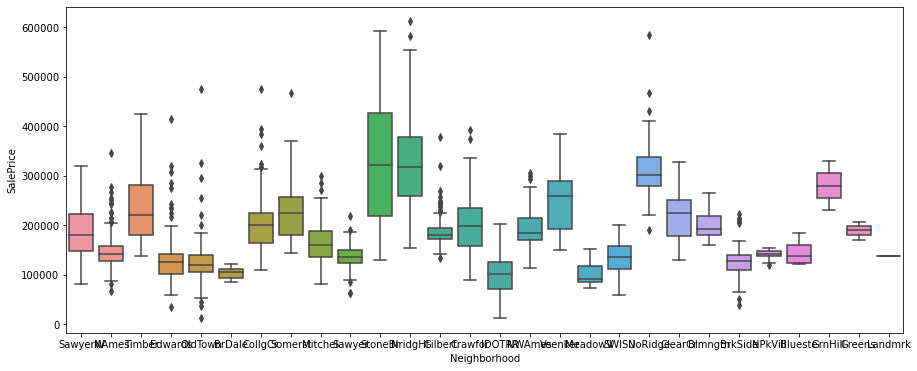

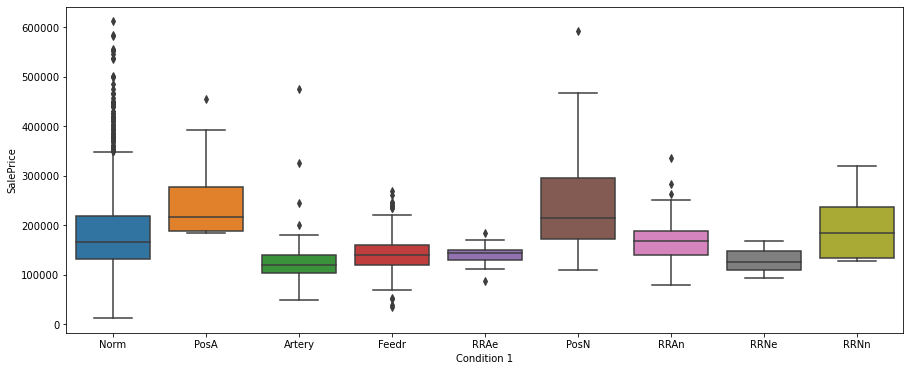

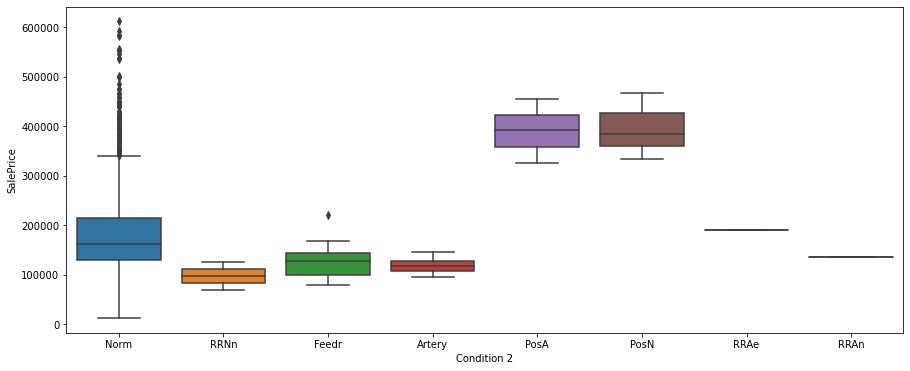

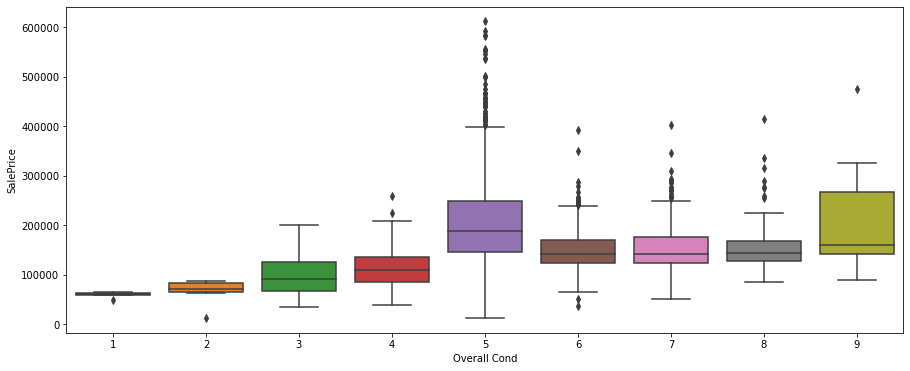

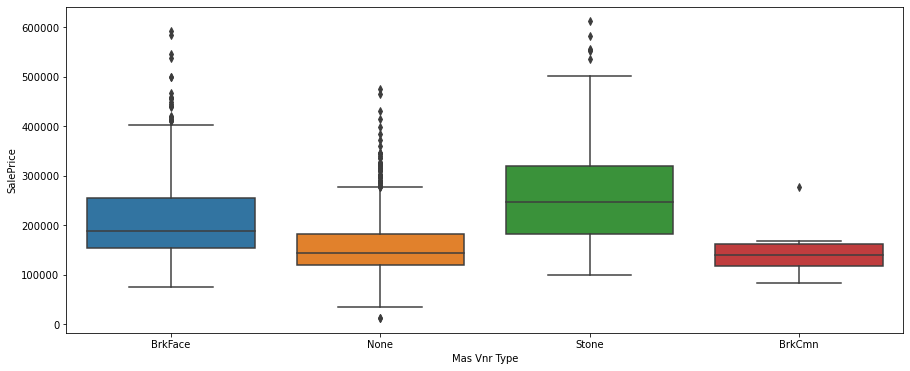

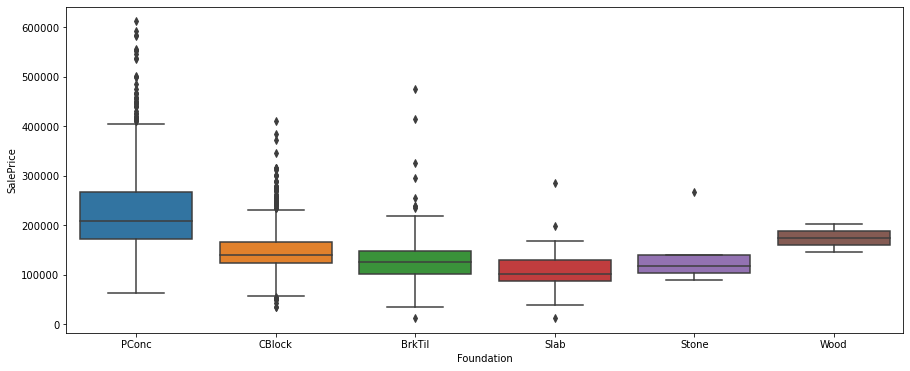

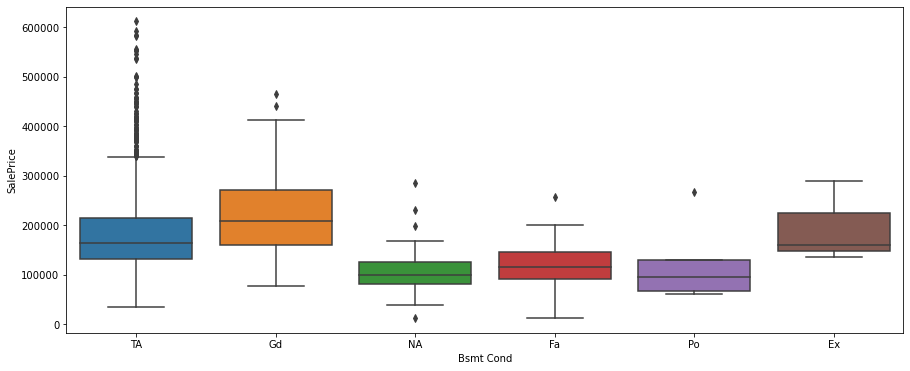

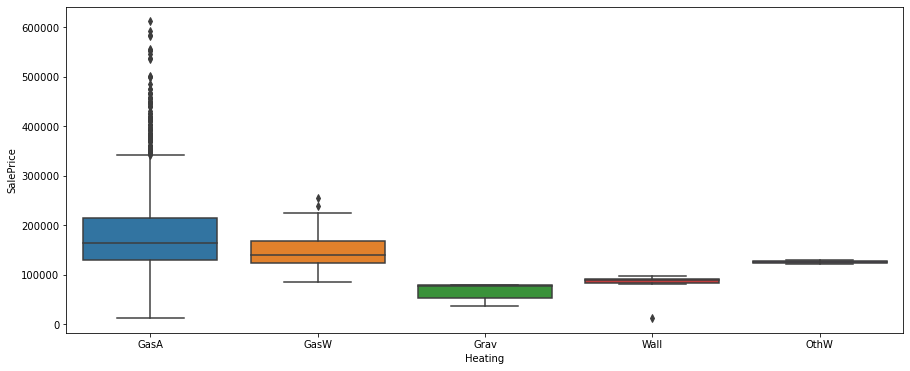

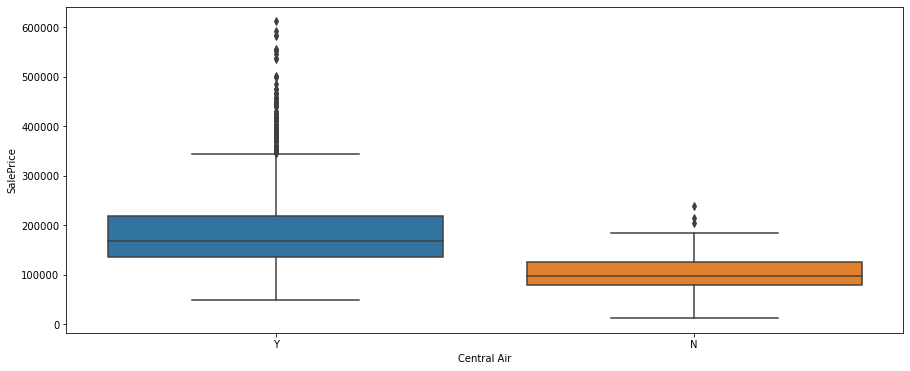

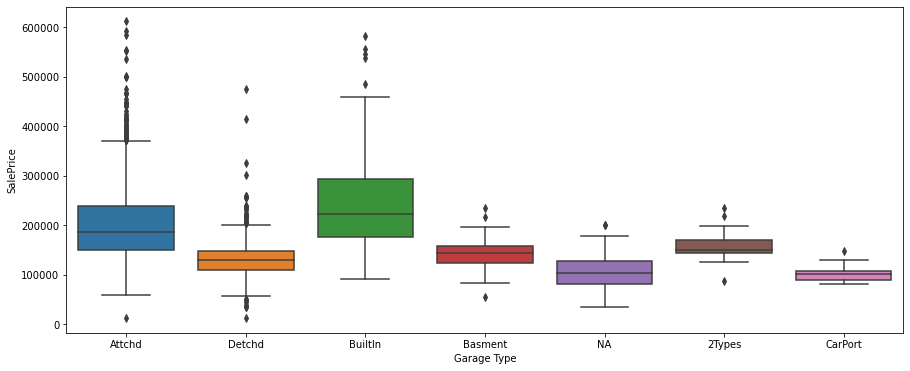

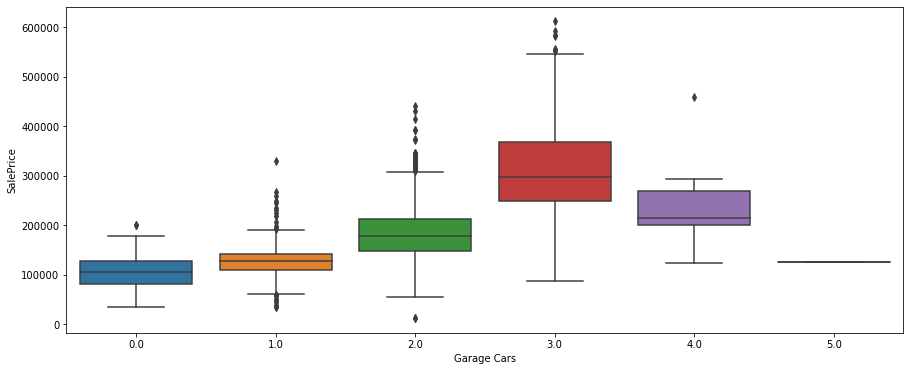

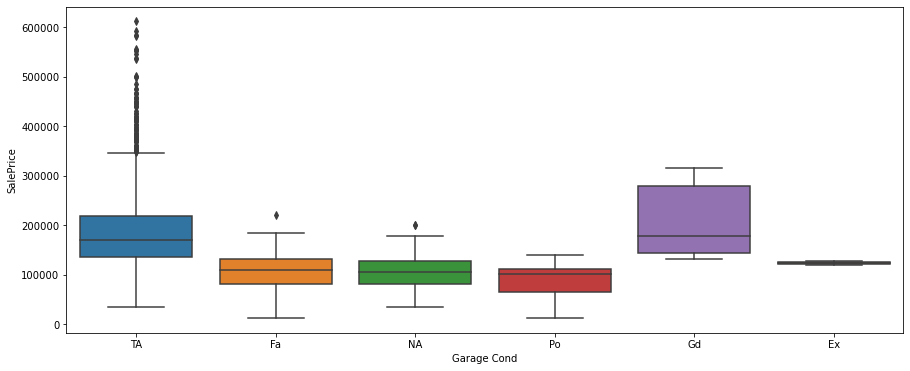

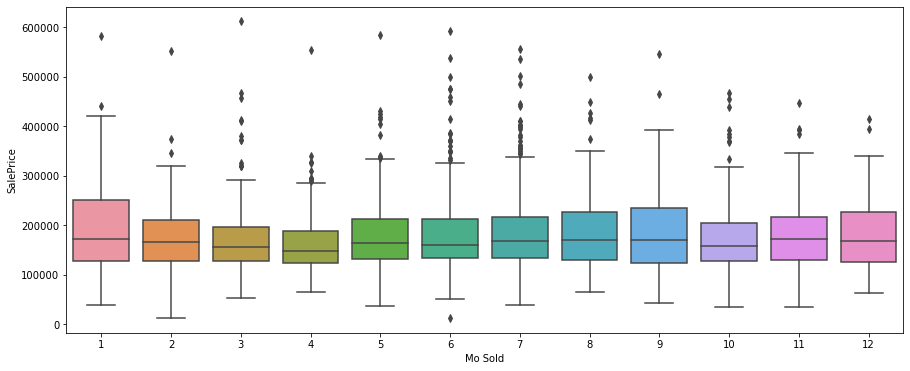

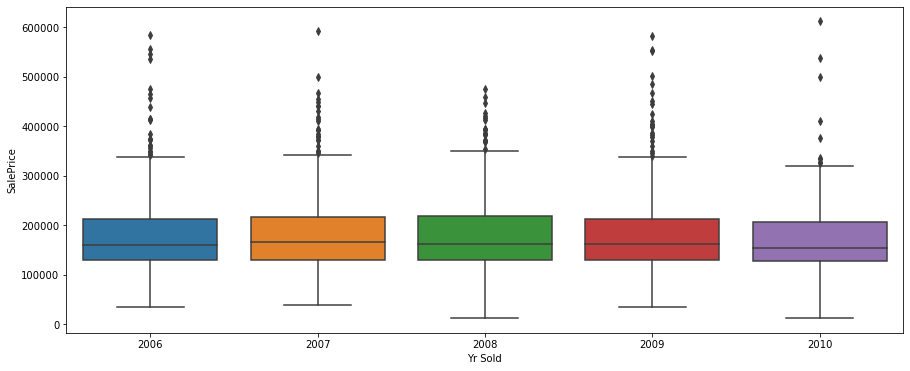

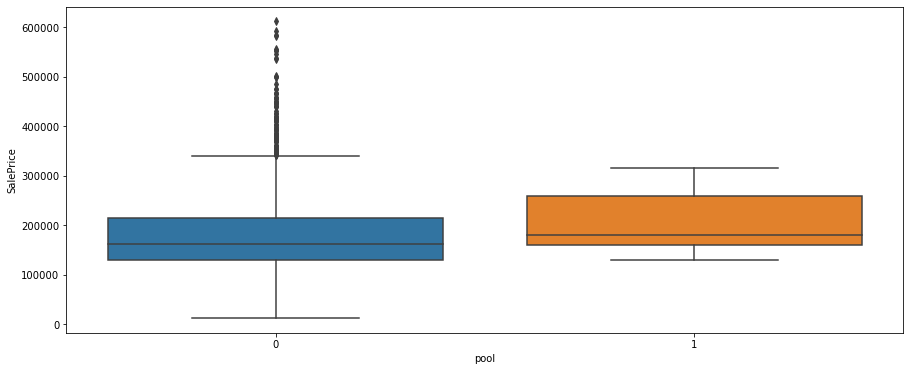

In [87]:
for i in cat_preds:
    fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    sns.boxplot( x = cat_preds [i][1:], y = train['SalePrice'])
    plt.rcParams.update({'figure.max_open_warning': 0})

## Check for Multicollinearity

In [88]:
train[['Year Built', 'Garage Yr Blt']].corr()

,Year Built,Garage Yr Blt
Year Built,1.00000,0.27476
Garage Yr Blt,0.27476,1.00000


In [89]:
train[['SF', 'TotRms AbvGrd']].corr()

,SF,TotRms AbvGrd
SF,1.000000,0.805444
TotRms AbvGrd,0.805444,1.000000


In [90]:
train[['Garage Cars', 'Garage Area']].corr()

,Garage Cars,Garage Area
Garage Cars,1.000000,0.893442
Garage Area,0.893442,1.000000


In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 93 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   LotFrontage      2051 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   LotShape         2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  LotConfig        2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   